# Analysis of pressure data

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import glob
%matplotlib notebook

TIME = 0
PRESSURE = 5
TRIG = 3

In [2]:
# This function reads the text file.
def read_txt(filename, n_cols=6):
    with open(filename,'r') as F:
        l=' '
        data=[]
        header=[]
        while len(l)>0:
            l=F.readline()
            s=l.strip().split(' ')
            if len(s)>=n_cols: # EXPECT n_cols VARIABLES. Less than this suggests corrupt data to ignore.
                if header==[]: header=[ss.split(':')[0] for ss in s[:n_cols]]
                data.append(np.array([float(ss.split(':')[1]) for ss in s[:n_cols]]))
    return header, np.vstack(data)

In [3]:
# This function converts pressure difference to velocity.
def bernoulli(dp,rho=1.225):
    return np.sqrt(np.abs(dp)/0.5/rho)*np.sign(dp)

In [4]:
# Main program start.
# Get list of files & read them.
txt_files=glob.glob("/Users/dduke/Downloads/Initial Testing/*.csv")

all_data=[]
for f in txt_files:
    header, data = read_txt(f)
    all_data.append(data)

In [5]:
# The timeRel seems to be coming too late , we need to move it earlier in time.
# Use the externalTrigger data to find out the time when the clock reset. Then shift back a few time steps.
# Extract the pressure profile at each of those times rather than relying on timeRel variable.

PRE_TRIGGER = 10
results = []
for data in all_data:
    falling_triggers = np.where(np.diff(data[:,TRIG])==-1)[0]
    for i in range(len(falling_triggers)):
        t0=falling_triggers[i]-PRE_TRIGGER
        if i<len(falling_triggers)-1: t1 = falling_triggers[i+1]-PRE_TRIGGER 
        else: t1=-1
        results.append( data[t0:t1,:] )

In [6]:
# Pressure sign is unsual. Filter negatives
for data in all_data:
    #data[:,PRESSURE]=data[:,PRESSURE]*(data[:,PRESSURE]>0)  # mask negatives
    data[:,PRESSURE]=np.abs(data[:,PRESSURE]) # remove sign
    #data[np.abs(data[:,PRESSURE])>1,PRESSURE]-=np.nanmin(data[:,PRESSURE]) # offset by lowest
    

<IPython.core.display.Javascript object>


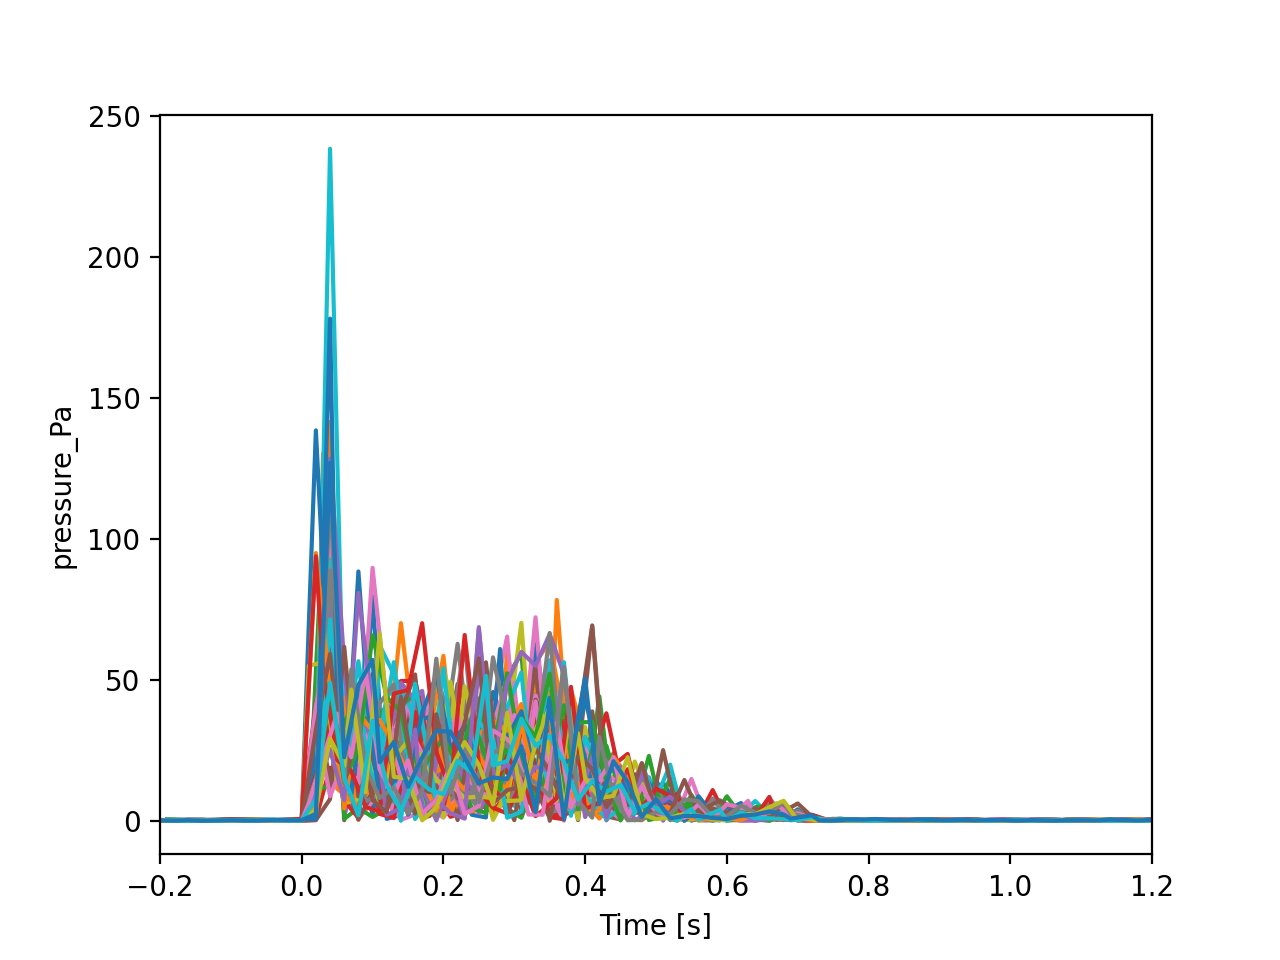

In [7]:
# Plot the raw data.
fig=plt.figure()
for data in results:
    plt.plot(data[:,TIME] - data[PRE_TRIGGER,TIME], data[:,PRESSURE])
plt.xlabel('Time [s]')
plt.ylabel(header[PRESSURE])
plt.xlim(-0.2,1.2)
plt.show();

<IPython.core.display.Javascript object>


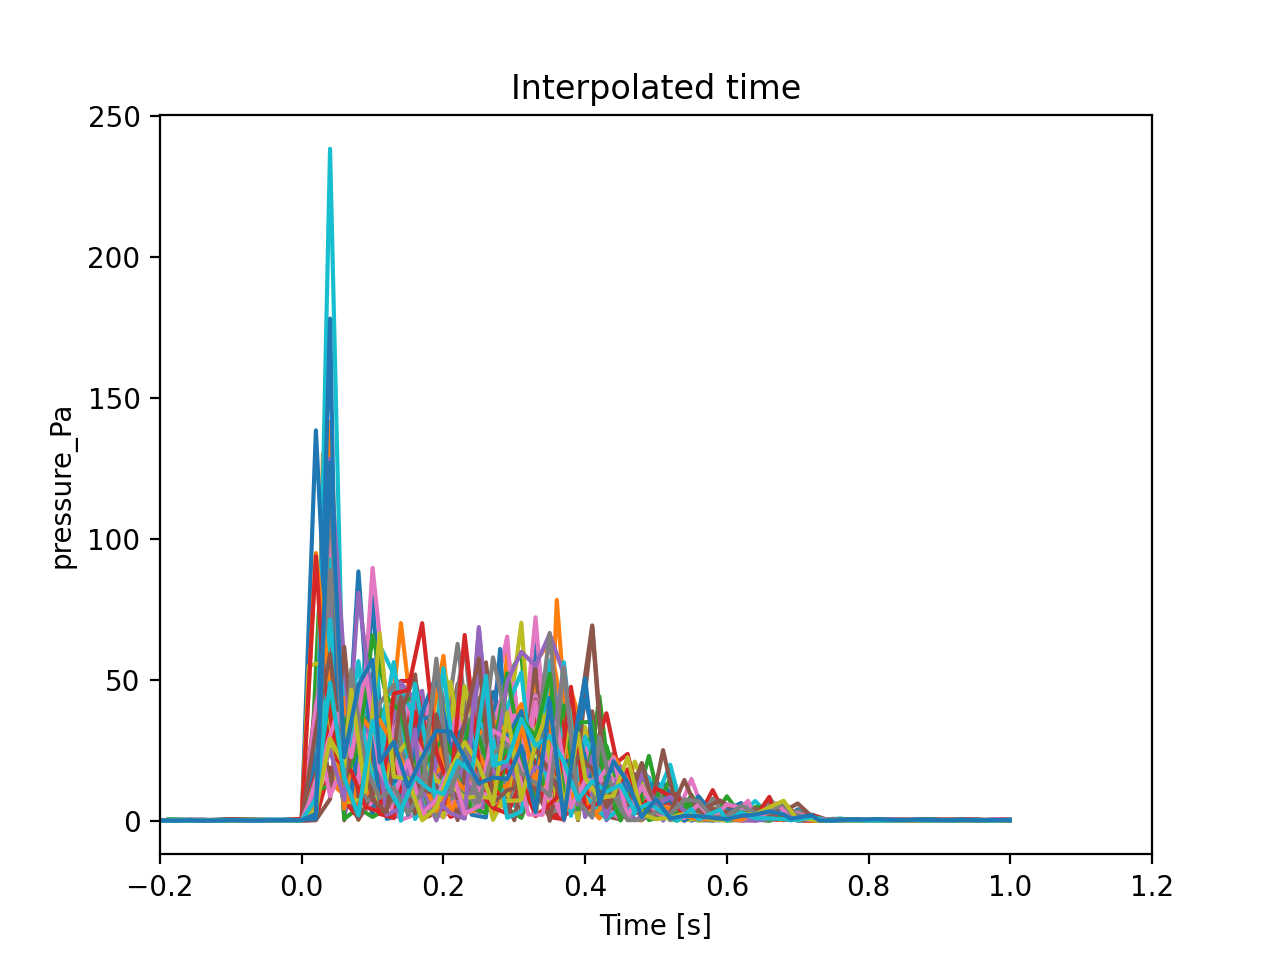

In [8]:
# Interpolate the raw data onto a consistent time base for averaging.

new_time = np.arange(-0.2, 1.0, 0.001) # interpolate onto a 1ms (1000 Hz) time base.
interp_results = []
for data in results:
        # Value is zero outside the valid data range.
        f = interp1d(data[:,TIME] - data[PRE_TRIGGER,TIME], data[:,PRESSURE], bounds_error=False, fill_value=0)
        interp_results.append( f(new_time) )
        
fig=plt.figure()
for data in interp_results:
    plt.plot(new_time, data)
plt.xlabel('Time [s]')
plt.ylabel(header[PRESSURE])
plt.title("Interpolated time")
plt.xlim(-0.2,1.2)
plt.show();

<IPython.core.display.Javascript object>


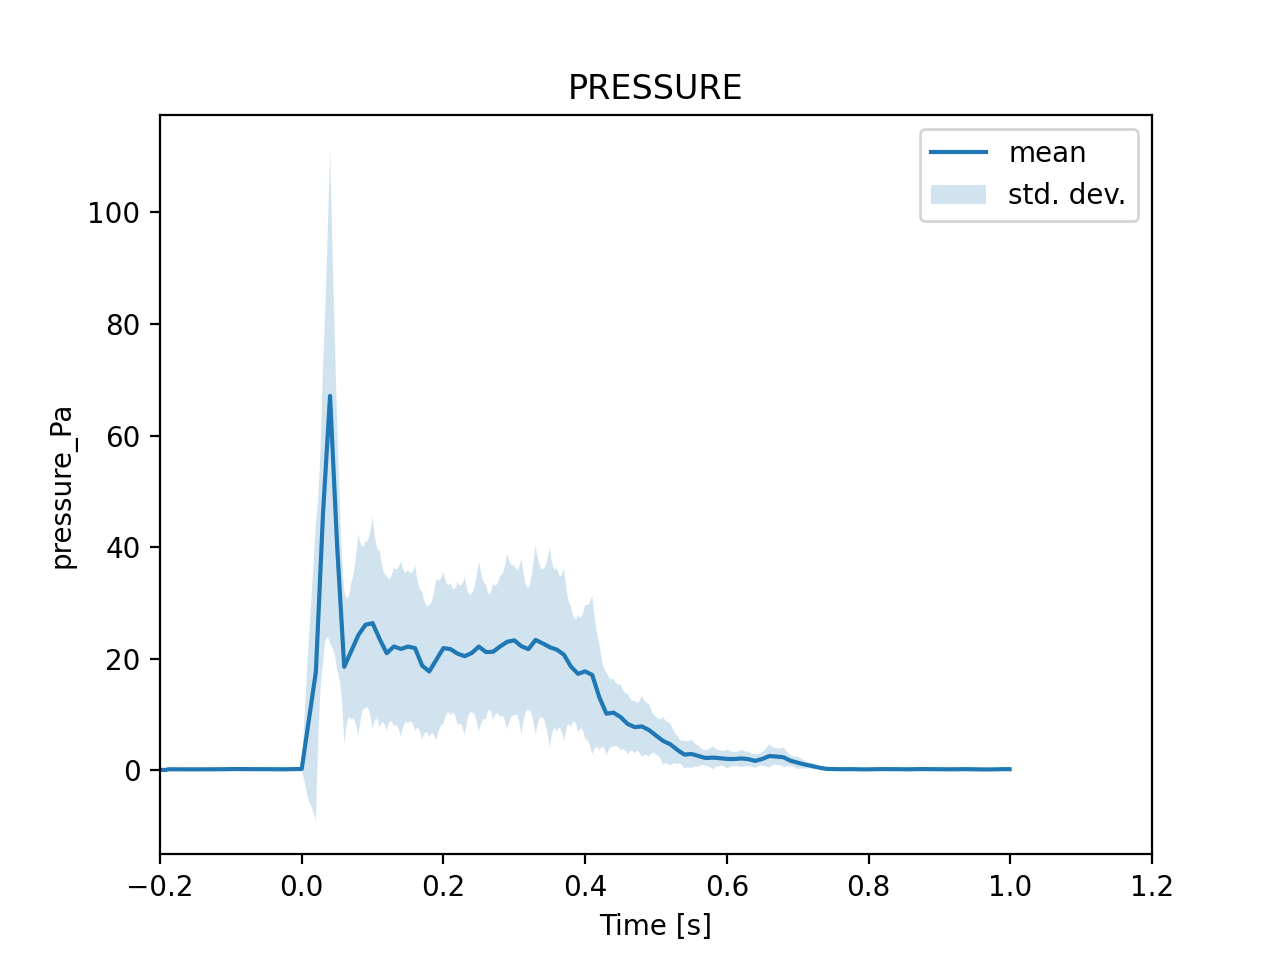

<IPython.core.display.Javascript object>


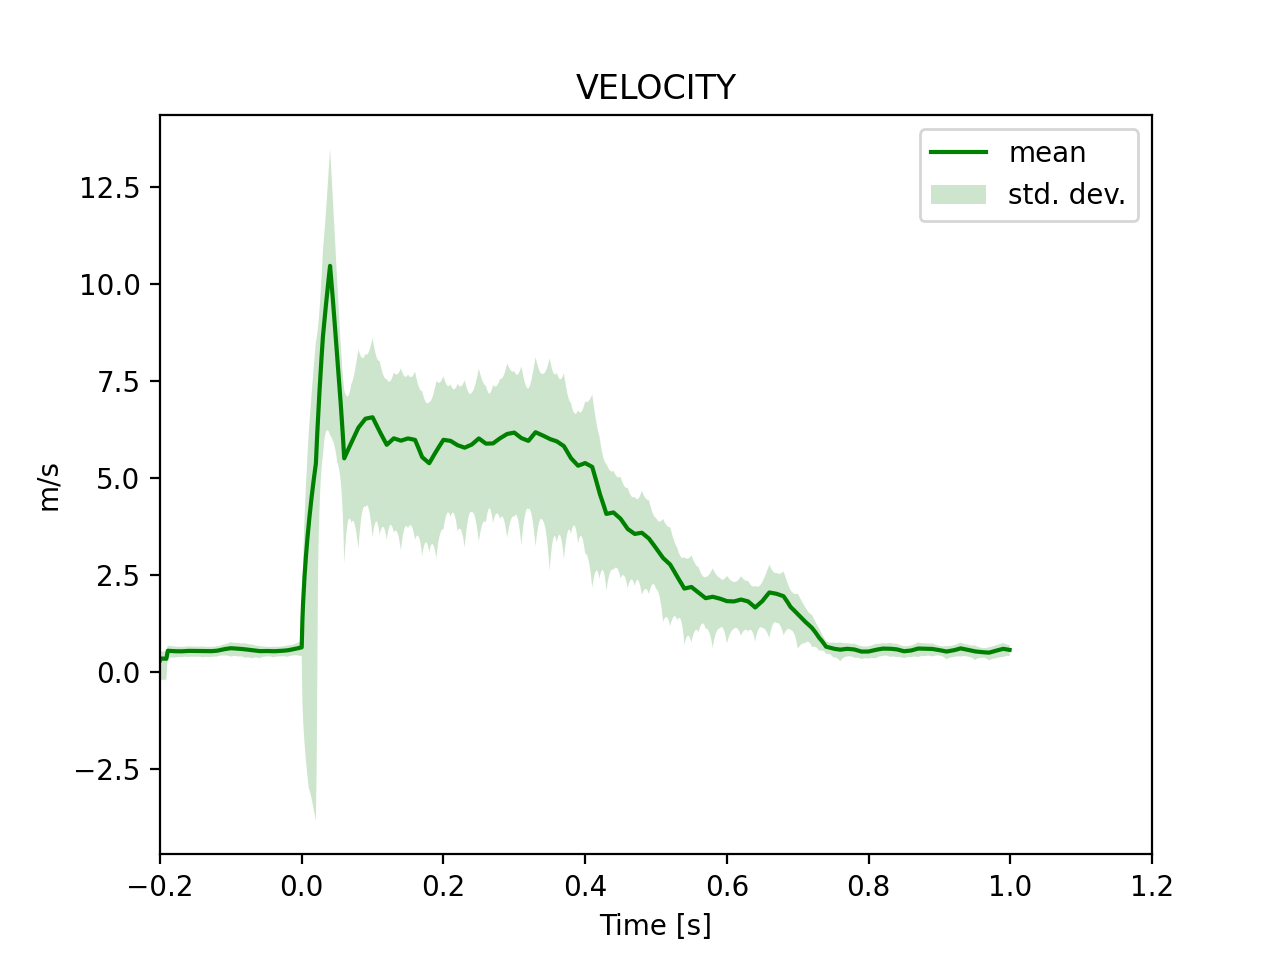

In [9]:
# Now show us the ensemble average and standard deviation.
# Calculate velocity as well.

mean = np.mean(interp_results,axis=0)
stdev =  np.std(interp_results,axis=0)

fig=plt.figure()
plt.plot(new_time, mean)
plt.fill_between(new_time, mean-stdev, mean+stdev, alpha=.2)
plt.xlabel('Time [s]')
plt.ylabel(header[PRESSURE])
plt.title("PRESSURE")
plt.legend(['mean','std. dev.'])
plt.xlim(-0.2,1.2)

fig=plt.figure()
plt.plot(new_time, bernoulli(mean),c='g')
plt.fill_between(new_time, bernoulli(mean-stdev), bernoulli(mean+stdev), alpha=.2,fc='g')
plt.xlabel('Time [s]')
plt.ylabel('m/s')
plt.title("VELOCITY")
plt.legend(['mean','std. dev.'])
plt.xlim(-0.2,1.2)
plt.show();